In [1]:
import tensorflow as tf

print ('Tensorflow version: ', tf.__version__)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import keras
print ('Keras version: ', keras.__version__)

Tensorflow version:  1.13.1


Using TensorFlow backend.


Keras version:  2.2.4


### Load required packages

In [2]:
from datetime import timedelta, date
import math
import copy
import os
import pickle
import pandas as pd
import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold', 'xtick.labelsize': 14, 'axes.labelsize': 14,
                    'axes.labelweight': 'bold', 'figure.figsize': (12, 8), 'axes.titlesize': 12})

from matplotlib import cm
import numpy as np

## configure print option
np.set_printoptions(suppress=True)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Current device in use:', device)

Current device in use: cuda:0


In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
def daterange(date1, date2):
    for n in range(int((date2 - date1).days) + 1):
        yield date1 + timedelta(n)

def date_range_list(start_dt, end_dt):
    date_list = []
    
    for dt in daterange(start_dt, end_dt):
        date = dt.strftime("%m%d")
        date_list.append(date)
        
    return date_list

In [6]:
def calculate_deviation(track_info, target_col, actual_col):
    dev = track_info[target_col].astype('float') - track_info[actual_col].astype('float')
    return dev

#### Get departure and arrival airport info

In [7]:
def get_airport_by_code(ICAO_code):
    airports_list = pd.read_csv('airports.dat', header=None, index_col=[0], 
                      names = ['Name', 'City', 'Country', 'IATA_code', 'ICAO_code', 'Latitude', 'Longitude',
                                'Altitude', 'Timezone', 'DST', 'Tz_timezone', 'Type', 'Source'])
    
    airport = airports_list[airports_list.ICAO_code == ICAO_code]
    
    if len(airport) == 1:
        airport_name = airport['Name'].values[0]
        airport_latitude = airport['Latitude'].values[0]
        airport_longitude = airport['Longitude'].values[0]
    else:
        return None, None, None
    
    return airport_name, airport_latitude, airport_longitude

### Build deep learning models: deep neural networks

#### Prepare traing and testing data for the DNN model

In [8]:
def reshape_data(df):
    lat_dev = calculate_deviation(df, 'target_Latitude', 'actual_Latitude')
    lng_dev = calculate_deviation(df, 'target_Longitude', 'actual_Longitude')
    #altitude_dev = calculate_deviation(df, 'targetAltitude', 'actualAltitude')
    data = pd.DataFrame({'x_velocity': df['x_velocity'], 'y_velocity': df['y_velocity'], 'speed': df['actualSpeed'], 
                         'alt': df['actualAltitude'], 'lat_dev': lat_dev, 'lng_dev': lng_dev})
    
    data.reset_index(drop=True, inplace=True)
    return data

def prepare_data(ref_col_name):
    input_scaler = MinMaxScaler()
    output_scaler = MinMaxScaler()
    
    train_index = list(np.arange(len(interpolated_df)))
    train_index.remove(test_index)

    train_data = pd.DataFrame()
    for i in train_index:
        new_data = reshape_data(interpolated_df[i])
        train_data = pd.concat([train_data, new_data], axis = 0, ignore_index = True)
                    
    test_data = reshape_data(interpolated_df[test_index])
        
    #print ('min: ', np.min(train_data[ref_col_name]))
    #print ('max: ', np.max(train_data[ref_col_name]))
    
    X_train = train_data
    Y_train = pd.DataFrame(train_data[ref_col_name].shift(-1))

    X_train.drop(X_train.index[len(X_train)-1], inplace = True)
    Y_train.drop(Y_train.index[len(Y_train)-1], inplace = True)

    X_train_n = input_scaler.fit_transform(X_train)
    Y_train_n = output_scaler.fit_transform(Y_train)
    
    X_test = test_data
    Y_test = pd.DataFrame(test_data[ref_col_name].shift(-1))
    
    X_test.drop(X_test.index[len(X_test)-1], inplace=True)
    Y_test.drop(Y_test.index[len(Y_test)-1], inplace=True)
    
    X_test_n = input_scaler.transform(X_test)
    Y_test_n = output_scaler.transform(Y_test)
    
    ind_list = [i for i in range(X_train.shape[0])]
    ind_list = shuffle(ind_list)
    
    X_train_n = X_train_n[ind_list, :]
    Y_train_n = Y_train_n[ind_list, :]
    
    return X_train, Y_train, X_train_n, Y_train_n, X_test_n, Y_test_n, input_scaler, output_scaler

#### Define commonly used function to transform the scaled data back to orignal values

In [9]:
def post_processing(model, file_name, hist):
    for key in hist.history.keys():
        plt.plot(hist.history[key],label=key)
    
    plt.title("loss={:5.6f}".format(hist.history["loss"][-1]))
    plt.legend()
    plt.yscale('log')
    plt.xlabel("Iteration", fontsize = 16)
    plt.ylabel("Loss", fontsize = 16)
    
def transform(scaler, val):
    original_val = scaler.inverse_transform(np.reshape(val, newshape = (-1, 1)))
    return original_val

def convert_to_actual_val(col_name, dev_pred = None):
    if dev_pred is None:
        res = np.reshape(np.array(interpolated_df[test_index][col_name])[1:], newshape = (-1, 1))
        res = res.flatten()
    else:
        res = np.reshape(np.array(interpolated_df[test_index][col_name])[1:], newshape = (-1, 1)) - dev_pred
        res = res.flatten()
        
    return res

In [10]:
def from_dev_to_lat_lng(tag, dev_val):
    if tag == 'latitude':
        y_pred_lat_dev = transform(lat_output_scaler, dev_val)
        Y_pred = convert_to_actual_val(col_name = 'target_Latitude', dev_pred = y_pred_lat_dev)
    elif tag == 'longitude':
        y_pred_lng_dev = transform(lng_output_scaler, dev_val)
        Y_pred = convert_to_actual_val(col_name = 'target_Longitude', dev_pred = y_pred_lng_dev)
    return Y_pred

#### Define function to plot figures for probabilistic prediction

In [11]:
def draw_figures(Y_test, y_pred_do, y_pred_do_mean, scaler, col_name):
    plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'xtick.labelsize': 14, 'axes.labelsize': 18,
                    'axes.labelweight': 'bold', 'figure.figsize': (14, 7), 'axes.titlesize': 12})
    f = plt.figure()
    for i in range(y_pred_do.shape[0]):
        plt.scatter(transform(scaler, Y_test), transform(scaler, y_pred_do[i, :]), c='blue', s = 0.1)

    plt.xlabel('Actual ' + col_name +  ' Deviation')
    plt.ylabel(col_name + ' Deviation Prediction')
    f.savefig("DNN_" + col_name + '_1'+ '.pdf', bbox_inches='tight')
    
    f = plt.figure()
    for i in range(y_pred_do.shape[0]):
        sca_true_bayes = plt.scatter(np.arange(0, Y_test.shape[0], 1),
                                     transform(scaler, y_pred_do[i, :]), s=0.05, c ='green', alpha = 0.9)

    sca_true_val = plt.scatter(np.arange(0, Y_test.shape[0], 1), transform(scaler, Y_test), s=20, c ='blue', alpha = 0.9)
    plt.ylabel(col_name + ' deviation', fontsize = 20, fontweight = 'bold')
    plt.legend((sca_true_val, sca_true_bayes), ('True value', 'Prediction'), loc='upper left', ncol=3)
    f.savefig("DNN_" + col_name + '_2'+ '.pdf', bbox_inches='tight')
    
    f = plt.figure()
    sca_true = plt.scatter(np.arange(0, Y_test.shape[0], 1), transform(scaler, Y_test), 
                           s=12, marker='s', color='b')

    sca_pred = plt.scatter(np.arange(0, Y_test.shape[0], 1), transform(scaler, y_pred_do_mean), 
                           s=12, marker='^', color='r')

    plt.xlabel('Time (Unit: 12 seconds)')
    plt.ylabel(col_name + ' deviation', fontsize = 20, fontweight = 'bold')

    plt.legend((sca_true, sca_pred), ('True value', 'Prediction Mean'), loc='upper right', ncol=3)
    
    f.savefig("DNN_" + col_name + '_3'+ '.pdf', bbox_inches='tight')

#### Define multi-step prediction function for DNN

In [12]:
## use the current deviation prediction to calculate the future latitude and longtitude, 
## replace the deviation along latitude and longitude in the input vector at the next time instant

def predict_multi_steps(steps = 100):
    pred_loc = list()
    
    input_data__ = copy.deepcopy(X_test_lat)
    if steps >= Y_test_lat.shape[0]:
        print ('Please input a reasonable step size')
    else:
        for i in range(steps):
            #print ('time step ', i, ':', X_test_lat[i, :])  
            if i == 0:
                data = copy.deepcopy(input_data__[i, :])
            else:
                data = copy.deepcopy(input_data__[i, :])
                data[3] = lat_pred_
                data[4] = lng_pred_

                        
            lat_pred_ = PyTorch_DNN_deterministic_pred(lat_model, np.reshape(data, (1, -1)))
            current_lat_pred = transform(lat_output_scaler, lat_pred_)
            next_lat = interpolated_df[test_index]['target_Latitude'][i+1] - current_lat_pred
                        
            lng_pred_ = PyTorch_DNN_deterministic_pred(lng_model, np.reshape(data, (1, -1)))
            current_lng_pred = transform(lng_output_scaler, lng_pred_)
            next_lng = interpolated_df[test_index]['target_Longitude'][i+1] - current_lng_pred
            
            pred_loc.append([next_lat[0][0], next_lng[0][0]])
        
    return pred_loc

## Part II: RNN model construction

In [13]:
def RNN_inverse_transform(index, normalized_val, Y_test):
    ind = np.arange(index, feature_dim * step_ahead, feature_dim)
    
    mu = RNN_output_scaler.mean_[ind]
    delta = np.sqrt(RNN_output_scaler.var_[ind])
    
    pred_val = normalized_val * delta + mu
    true_val =  Y_test[:, :, index] * delta + mu
    
    return pred_val, true_val

def inverse_RNN_pred(index, normalized_val):
    ind = np.arange(index, feature_dim * step_ahead, feature_dim)
    
    mu = RNN_output_scaler.mean_[ind]
    delta = np.sqrt(RNN_output_scaler.var_[ind])
    
    pred_val = normalized_val * delta + mu
    
    return pred_val

#### Implementation of Bayesian RNN

In [14]:
def RNN_probabilistic_prediction(model, X_test, no_output, n_iter=500):
    kdp = KerasDropoutPrediction(model, no_output)
    y_pred_do = kdp.predict(X_test, n_iter)
    y_pred_do_mean = y_pred_do.mean(axis=0)

    y_pred = np.array(model.predict(X_test))
    
    return y_pred_do, y_pred_do_mean, y_pred

## Main Program

The main program has **five major** parts:

* Read exported flight trajectory data
* Preprocess flight trajectory data: remove duplicated data, interpolate the position data if the duration between two consecutive points is larger than a threshold value
* Train two DNN models for flight laitude and longitude deviation prediction, no need to build deviation model for altitude because the altitude between flight plan and actual flight trajectory is almost zero
* Train two LSTM RNN models for flight trajectory prediction
* Integrate the two trained models

#### Define global variables

In [17]:
use_trained_model = True

n_iter = 1000

feature_dim = 6

start_dt = date(2018, 12, 19)
end_dt = date(2019, 2, 8)
date_list = date_range_list(start_dt, end_dt)

date_list.remove('1222')
date_list.remove('0118')
date_list.remove('0125')
date_list.remove('0126')
date_list.remove('0129')

flightID_dir = ''

flight_ID = 'AAL598'

#### Part I: data processing

In [18]:
flight_data = 'SFDPS' +'_'+ str(start_dt) + '-' + str(end_dt) + '.pkl'
per_flight_df = flight_ID + '_' + str(start_dt) + '-' + str(end_dt) +'.pkl'

if os.path.exists(flight_data) and os.path.exists(per_flight_df) and True:
    SFDPS_data = open(flight_data, 'rb')
    common_flight = pickle.load(SFDPS_data)
    
    flight_trajec = open(per_flight_df, 'rb')
    interpolated_df = pickle.load(flight_trajec)
    #show_deviation()
else:
    common_flight = identify_common_flight()
    common_flight = sorted(common_flight, key=str.lower)
    
    #########################################################################
    with open(flight_data, 'wb') as f:
         pickle.dump(common_flight, f)
    
    data = generate_flight_data(flight_ID)
    
    ########################################################################
    interpolated_df = process_trajectory()

    ########################################################################
    show_deviation()
    
    with open(per_flight_df, 'wb') as f:
        pickle.dump(interpolated_df, f)

#### Part II: Build DNN Model 

In [21]:
def PyTorch_build_DNN_model(X_train, Y_train, dropout = 0.1, learning_rate=0.001, iterations = 10000):
    X_train_pt = torch.from_numpy(X_train).type(torch.FloatTensor)
    Y_train_pt = torch.from_numpy(Y_train).type(torch.FloatTensor)
    
    net_dropped = torch.nn.Sequential(
        torch.nn.Linear(feature_dim, 32),
        torch.nn.Dropout(dropout),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 64),
        torch.nn.Dropout(dropout),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 32),
        torch.nn.Dropout(dropout),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
    )
    
    net_dropped.to(device)
    
    optimizier_drop = torch.optim.Adam(net_dropped.parameters(), lr=learning_rate)
    loss_drop = torch.nn.MSELoss()

    for t in range(iterations):
        out = net_dropped(X_train_pt.to(device))  # input x and predict based on x
        loss = loss_drop(out.to(device), Y_train_pt.to(device))  # must be (1. nn output, 2. target)
        optimizier_drop.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizier_drop.step()  # apply gradients
        
        #if t%1000 == 0:
        #    print("Epoch %d :  %.5f" % (t, loss))
    
    return net_dropped

def PyTorch_DNN_probabilistic_pred(model, X_test, n_iter):
    X_test_pt = torch.from_numpy(X_test).type(torch.FloatTensor)
    y_pred_drop = np.zeros(shape = (n_iter, X_test.shape[0]))
    
    for i in range(n_iter):
        model.eval()
        for m in model.modules():
            if m.__class__.__name__.startswith('Dropout'):
                model.train()
    
        y_pred_dropped = model(X_test_pt.to(device))
        y_pred_drop[i, :] = torch.Tensor.cpu(y_pred_dropped).data.numpy().reshape(1, X_test.shape[0])
    
    y_pred_drop_mean = np.mean(y_pred_drop, axis = 0)
    
    return y_pred_drop, y_pred_drop_mean

def PyTorch_DNN_deterministic_pred(model, X_test):
    X_test_pt = torch.from_numpy(X_test).type(torch.FloatTensor)
    model.eval()
    
    y_pred = model(X_test_pt.to(device))
    y_pred = torch.Tensor.cpu(y_pred).data.numpy().reshape(1, X_test.shape[0])
    
    return y_pred

#### DNN prediction -- combined results

In [22]:
def DNN_combined_results():
    no_pred = 5
    s_t = 35
    plt.rcParams.update({'ytick.labelsize': 14})
    
    f = plt.figure()
    for i in range(n_iter):
        lat_dev_pred_ = y_pred_do_lat[i, :]
        y_pred_do_lat_p = transform(lat_output_scaler, lat_dev_pred_)
        Y_lat_pred_p = convert_to_actual_val(col_name = 'target_Latitude', dev_pred = y_pred_do_lat_p)

        lng_dev_pred_ = y_pred_do_lng[i, :]
        y_pred_do_lng_p = transform(lng_output_scaler, lng_dev_pred_)
        Y_lng_pred_p = convert_to_actual_val(col_name = 'target_Longitude', dev_pred = y_pred_do_lng_p)

        prob_ = plt.scatter(Y_lng_pred_p[s_t:no_pred+s_t], Y_lat_pred_p[s_t:no_pred+s_t], s = 60, alpha = 0.1, c = 'magenta', 
                           label = 'Probabilistic model')

        
    Lat_plan = convert_to_actual_val(col_name = 'target_Latitude')
    Lng_plan = convert_to_actual_val(col_name = 'target_Longitude')
    
    
    prob_mean = plt.scatter(from_dev_to_lat_lng('longitude', y_pred_do_mean_lng)[s_t:no_pred+s_t], 
                from_dev_to_lat_lng('latitude', y_pred_do_mean_lat)[s_t:no_pred+s_t], s = 130, alpha = 0.8, c = 'black',
                marker = 'x', label = 'Mean prediction')

    determin_ = plt.scatter(Y_lng_pred[s_t:no_pred+s_t], Y_lat_pred[s_t:no_pred+s_t], s = 50, c = '#85C1E9',
                            marker = 'o', label = 'Deterministic model')

    actual_ = plt.scatter(Y_lng_true[s_t:no_pred+s_t], Y_lat_true[s_t:no_pred+s_t], s = 50, alpha = 0.9, 
                          color = 'green', label = 'Actual value')
    
    plan_ = plt.scatter(Lng_plan[s_t:no_pred+s_t], Lat_plan[s_t:no_pred+s_t], s = 50, alpha = 1, c = '#F39C12', 
                        marker = 'H', label = 'Filed flight plan')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    _ = plt.legend(handles = [prob_, prob_mean, determin_, actual_, plan_], loc = 0)
    
    
    #plt.axis('equal')
    plt.tight_layout()
    plt.show()
    f.savefig('combined_result.pdf', bbox_inches='tight')

In [23]:
def DNN_deviation_scatter_plot():
    #dev_baseline_plt = plt.scatter(lat_dev_baseline, lng_dev_baseline, 
    #                s = 40, c = 'blue', alpha = 0.8, label = 'Deviation between TT and AT')
    
    plt.figure()
    ax = plt.gca()

    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    
    dev_actual_pred_plt = plt.scatter(lat_dev_actual_pred, lng_dev_actual_pred, s = 40, c = 'magenta', 
                                      alpha = 0.35, label = 'Difference between PT and AT')

    plt.xlabel('Latitude deviation')
    plt.ylabel('Longitude deviation')
    _ = plt.legend(handles = [dev_actual_pred_plt], loc = 2)
    
    plt.tight_layout()

In [24]:
def DNN_deviation_distribution_plot():
    one_lat_dev = calculate_deviation(interpolated_df[test_index], 'target_Latitude', 'actual_Latitude')
    one_lng_dev = calculate_deviation(interpolated_df[test_index], 'target_Longitude', 'actual_Longitude')

    one_lat_to_miles = 70

    f = plt.figure(figsize=(18, 6))
    f.add_subplot(121)
    plt.hist(one_lat_to_miles * lat_dev_actual_pred.T, alpha = 1, label='DNN Model', color = 'blue', bins = 100)
    plt.hist(one_lat_to_miles * DNN_Y_lat_train.values[1:2000], alpha = 0.6, label='Historical', color = 'green', bins = 100)
    plt.xlabel('Miles')
    plt.ylabel('Frequency')
    plt.title('The latitude deviation ' + flight_ID, fontsize = 20)
    plt.legend(loc='upper right')

    one_lng_to_miles = 69
    f.add_subplot(122)
    plt.hist(one_lat_to_miles * lng_dev_actual_pred.T, alpha=1, label='DNN Model', color = 'blue', bins = 100)
    plt.hist(one_lat_to_miles * DNN_Y_lng_train.values[1:2000], alpha=0.6, label='Historical', color = 'green', bins = 100)
    plt.xlabel('Miles')
    plt.ylabel('Frequency')
    plt.title('The longitude deviation ' + flight_ID, fontsize = 20)
    plt.legend(loc='upper right')

#### Uncertainty Reduction in DNN

In [25]:
def DNN_uncertainty_reduction():
    n_groups = 2

    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    sd_baseline = (np.std(lat_dev_baseline), np.std(lng_dev_baseline))
    sd_pred_actual = (np.std(lat_dev_actual_pred), np.std(lng_dev_actual_pred))
    
    plt.figure()
    rects1 = plt.bar(index, sd_baseline, bar_width, alpha = opacity, color='b', label='Historical Data')

    rects2 = plt.bar(index + bar_width, sd_pred_actual, bar_width, alpha = opacity, color='g', label='DNN Model')


    plt.ylabel(r'$\sigma$ of trajectory deviation')
    plt.xticks([0.17, 1.17], ('Latitude', 'Longitude'))
    plt.legend(loc = 2)

    plt.tight_layout()
    plt.show()

In [26]:
def DNN_calculate_deviation():

    ### baseline 
    lat_dev_baseline = np.abs(DNN_Y_lat_train.values)
    lng_dev_baseline = np.abs(DNN_Y_lng_train.values)

    ### model prediction
    #test_target_lat = np.array(interpolated_df[test_index]['target_Latitude']).T
    #test_target_lng = np.array(interpolated_df[test_index]['target_Longitude']).T

    #dev_target_actual_lat = np.abs(test_target_lat[1:n+1] - Y_lat_true[:n].T)
    #dev_target_actual_lng = np.abs(test_target_lng[1:n+1] - Y_lng_true[:n].T)
    
    n = y_pred_do_mean_lat.shape[0]
    lat_dev_actual_pred = np.abs(from_dev_to_lat_lng('latitude', y_pred_do_mean_lat)[:n].T - Y_lat_true[:n].T)
    lng_dev_actual_pred = np.abs(from_dev_to_lat_lng('longitude', y_pred_do_mean_lng)[:n].T - Y_lng_true[:n].T)

    lat_mu_reduction = (np.mean(lat_dev_baseline) - np.mean(lat_dev_actual_pred))/np.mean(lat_dev_baseline)
    lng_mu_reduction = (np.mean(lng_dev_baseline) - np.mean(lng_dev_actual_pred))/np.mean(lng_dev_baseline)
    
    lat_sd_reduction = (np.std(lat_dev_baseline) - np.std(lat_dev_actual_pred))/np.std(lat_dev_baseline)
    lng_sd_reduction = (np.std(lng_dev_baseline) - np.std(lng_dev_actual_pred))/np.std(lng_dev_baseline)
    
    return lat_dev_baseline, lng_dev_baseline, lat_dev_actual_pred, lng_dev_actual_pred, lat_mu_reduction, lng_mu_reduction, \
           lat_sd_reduction, lng_sd_reduction

#### DNN multi-step prediction

In [27]:
def DNN_multi_step_prediction():
    steps = 10
    DNN_multi_pred = predict_multi_steps(steps) ## start from time step 1

    DNN_multi_plt = plt.scatter(np.array(DNN_multi_pred)[:, 0], np.array(DNN_multi_pred)[:, 1], 
                                s = 30, alpha = 0.6, marker = 's', c = 'red', label = 'DNN Prediction')

    actual_multi_plt = plt.scatter(Y_lat_true[0:steps], Y_lng_true[0:steps], s = 30, c = 'blue', alpha = 0.6, 
                                   label = 'Actual Values')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    _ = plt.legend(handles = (DNN_multi_plt, actual_multi_plt), loc = 1)

### Part III: Build RNN Model

In [28]:
from keras.models import load_model

from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, Input, GRU
from keras.models import Sequential, Model
from keras import optimizers
from keras.regularizers import l2
import keras.backend as K

config = tf.ConfigProto(device_count = {'GPU': 2 , 'CPU': 8})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

print (K.tensorflow_backend._get_available_gpus())

from tensorflow.python.client import device_lib

print('Local devices', device_lib.list_local_devices())

['/job:localhost/replica:0/task:0/device:GPU:0']
Local devices [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18220417899310990849
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2958934016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3244230486831153066
physical_device_desc: "device: 0, name: GeForce GTX 745, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [29]:
class KerasDropoutPrediction(object):
    def __init__(self, model, no_output = 1):
        model_output = list()
        for i in np.arange(no_output, 0, -1):
            model_output.append(model.layers[-i].output)
            
        self.f = K.function([model.layers[0].input, K.learning_phase()], model_output)
        self.model_output = no_output
    
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
            
        if self.model_output > 1:
            result = np.array(result).reshape(n_iter, self.model_output, len(x), -1)
        else:
            result = np.array(result).reshape(n_iter, len(x)).T
            
        return result

In [30]:
## Define the sliding window size
def generate_RNN_data(window_size = 10, step_ahead = 5):
    ## Copy the flight trajectory
    RNN_input_data = copy.deepcopy(interpolated_df)

    ## Drop unnecessary columns
    cols_to_drop = ['arrivalPoint', 'airline', 'departurePoint', 'actualPosition', 'targetPosition', 
                    'target_Latitude', 'target_Longitude', 'targetAltitude', 'actualPositionTime']
    
    days = len(RNN_input_data)
    for i in range(days):
        RNN_input_data[i].drop(cols_to_drop, axis = 1, inplace=True)

    RNN_train_data = pd.DataFrame()
    RNN_test_data = pd.DataFrame()
    for i in range(days):
        series = pd.DataFrame()
        series_s = RNN_input_data[i]
        
        for j in np.arange(0, window_size + step_ahead):
            series = pd.concat([series, series_s.shift(-j)], axis = 1)
            
        series.dropna(axis = 0, inplace = True)
        
        if i != test_index:
            ## insert the start and end tags for each record
            RNN_train_data = pd.concat([RNN_train_data, series])
        else:
            RNN_test_data = pd.concat([RNN_test_data, series])
    
    
    X_train_data_ = RNN_train_data.iloc[:,:feature_size]
    Y_train_data_ = RNN_train_data.iloc[:,feature_size:]
    
    X_test_data_ = RNN_test_data.iloc[:,:feature_size]
    Y_test_data_ = RNN_test_data.iloc[:,feature_size:]
        
    RNN_input_scaler = StandardScaler()
    RNN_output_scaler = StandardScaler()

    X_train_data = RNN_input_scaler.fit_transform(X_train_data_)
    X_test_data = RNN_input_scaler.transform(X_test_data_)

    Y_train_data = RNN_output_scaler.fit_transform(Y_train_data_)
    Y_test_data = RNN_output_scaler.transform(Y_test_data_)

    X_train = np.array(X_train_data).reshape(X_train_data.shape[0], window_size, feature_dim)
    Y_train = np.array(Y_train_data).reshape(Y_train_data.shape[0], step_ahead, feature_dim)

    X_test = np.array(X_test_data).reshape(X_test_data.shape[0], window_size, feature_dim)
    Y_test = np.array(Y_test_data).reshape(Y_test_data.shape[0], step_ahead, feature_dim)
    
    return X_train_data_, Y_train_data_, X_test_data_, Y_test_data_, X_train, Y_train, X_test, \
            Y_test, RNN_input_scaler, RNN_output_scaler

In [31]:
def build_RNN_model(idrop, rdrop, odrop, epochs, weight_decay, flag):
    inputs = Input(shape=(window_size, feature_dim))

    RNN_model = LSTM(50, return_sequences = True, activation = 'relu', kernel_regularizer = l2(weight_decay),
                     recurrent_regularizer=l2(weight_decay), dropout=idrop, recurrent_dropout=rdrop)(inputs)
    RNN_model = Dropout(odrop)(RNN_model)
    
    RNN_model = LSTM(50, return_sequences = False, activation = 'relu', kernel_regularizer = l2(weight_decay), 
                    recurrent_regularizer=l2(weight_decay), dropout=idrop, recurrent_dropout=rdrop)(RNN_model)
    RNN_model = Dropout(odrop)(RNN_model)
    
    RNN_model = keras.layers.Reshape(target_shape = (1, 50))(RNN_model)
    
    RNN_model = Flatten()(RNN_model)

    ## prediction
    pred_speed = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay),
                            bias_regularizer=l2(weight_decay))(RNN_model)

    pred_alt = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay),
                            bias_regularizer=l2(weight_decay))(RNN_model)

    pred_x = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay),
                            bias_regularizer=l2(weight_decay))(RNN_model)

    pred_y = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay),
                            bias_regularizer=l2(weight_decay))(RNN_model)

    pred_lat = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay))(RNN_model)

    pred_lng = Dense(units = step_ahead, activation='linear', kernel_regularizer=l2(weight_decay))(RNN_model)
    
    if flag:
        RNN_model = Model(inputs=[inputs], outputs=[pred_alt, pred_x, pred_y])

        RNN_model.compile(loss="mse", optimizer=optimizers.adam(lr=0.001))
        #RNN_model.summary()

        RNN_hist = RNN_model.fit(X_train, [Y_train[:, :, 1], Y_train[:, :, 2], Y_train[:, :, 3]], 
                                 shuffle = True, verbose=0, epochs = epochs, batch_size = 2048)
    else:
        RNN_model = Model(inputs=[inputs], outputs=[pred_lat, pred_lng])

        RNN_model.compile(loss="mse", optimizer=optimizers.adam(lr=0.001))
        #RNN_model.summary()

        RNN_hist = RNN_model.fit(X_train, [Y_train[:, :, 4], Y_train[:, :, 5]], shuffle = True, 
                                 verbose=0, epochs = epochs, batch_size = 2048)
    
    return RNN_model, RNN_hist

#### Define the basic configuration of LSTM

In [32]:
window_size = 20
step_ahead = 5
RNN_pred_steps = 2

feature_size = window_size * feature_dim

col_names = ['Speed', 'Altitude', 'x_velocity', 'y_velocity', 'Latitude', 'Longitude']

#### Visualization of one-step LSTM prediction

In [33]:
def RNN_one_step_position_pred():
    plt.figure()
    a = np.arange(col_names.index('Latitude'), feature_size, feature_dim)
    b = np.arange(col_names.index('Longitude'), feature_size, feature_dim)

    start_index = 0
    end_index = 6

    legend_input = plt.scatter(X_test_data_.iloc[start_index, a].values, X_test_data_.iloc[start_index, b].values, 
                               s = 60, c = 'magenta', label = 'Input Data', marker = 'o')

    for index_ in range(start_index, end_index):
        legend_obs = plt.scatter(lat_test[index_, :], lng_test[index_, :], s = 80, c ='blue', 
                                 label ='Actual value', marker = 'x')

        if index_ == start_index:
            legend_pred = plt.scatter(RNN_lat_d[index_, :], RNN_lng_d[index_, :], s = 50, c= 'green', 
                                      marker = 's', label = 'Prediction')
        else:
            _ = plt.scatter(RNN_lat_d[index_, 4], RNN_lng_d[index_, 4], s = 50, marker = 's', c= 'green')

    _ = plt.legend(handles = [legend_input, legend_obs, legend_pred], loc = 2)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

#### Altitude Prediction

In [34]:
def RNN_altitude_prediction():
    
    a = np.arange(col_names.index('Altitude'), feature_size, feature_dim)

    start_index = 0
    end_index = 6

    f = plt.figure(figsize = (12, 6))
    legend_input = plt.scatter(range(window_size), X_test_data_.iloc[start_index, a].values, s = 60, 
                               c = 'magenta', label = 'Input Data', marker = 'o')

    for index_ in range(start_index, end_index):
        if index_ == start_index:
            legend_obs = plt.scatter(range(window_size, window_size + step_ahead), 
                                 alt_test[index_, :], s = 80, c ='blue', label ='Actual Value', marker = 'x')

            legend_pred = plt.scatter(range(window_size, window_size + step_ahead), 
                                      alt_model_pred[index_, :], s = 100, c= 'green', marker = '.', label = 'RNN Prediction')
        else:
            legend_obs = plt.scatter(range(window_size + step_ahead + index_-1, window_size + step_ahead+ index_), 
                                 alt_test[index_, 4], s = 80, c ='blue', label ='Actual Value', marker = 'x')

            _ = plt.scatter(range(window_size + step_ahead + index_-1, window_size + step_ahead+ index_),
                            alt_model_pred[index_, 4], s = 100, marker = '.', c= 'green')

    plt.ylabel('Altitude (Unit: feet)', fontsize =16) 
    plt.xlabel('Time (Unit: 12 seconds)', fontsize =16)
    _ = plt.legend(handles = [legend_input, legend_obs, legend_pred], loc = 2)
    f.savefig('RNN_Alt.pdf', bbox_inches='tight')

In [35]:
#RNN_altitude_prediction()

### Integration of two models

In [36]:
def create_RNN_pred_record(input_data, flag, step):
    inversed_data = np.zeros((1, step_ahead, feature_dim))
    input_data = input_data.reshape(-1, window_size, feature_dim)
    
    model_state_pred = np.array(state_RNN_model.predict(input_data))
    
    if step == 0:
        model_lat_pred = RNN_lat_mu[row_index + step*step_ahead, :]
        model_lng_pred = RNN_lng_mu[row_index + step*step_ahead, :]
        model_alt_pred = RNN_alt_mu[row_index + step*step_ahead, :]
    else:
        Y_model_pred = np.array(lat_lng_RNN_model.predict(input_data))
        model_lat_pred = inverse_RNN_pred(col_names.index('Latitude'), Y_model_pred[0, :, :])
        model_lng_pred = inverse_RNN_pred(col_names.index('Longitude'), Y_model_pred[1, :, :])
        model_alt_pred = inverse_RNN_pred(col_names.index('Altitude'), model_state_pred[0, :, :])

    model_x_velocity_pred = inverse_RNN_pred(col_names.index('x_velocity'), model_state_pred[1, :, :])
    model_y_velocity_pred = inverse_RNN_pred(col_names.index('y_velocity'), model_state_pred[2, :, :])
        
    if flag:
        model_lat_pred = model_lat_pred + DNN_RNN_correction[0] #+ np.arange(1, 6) * DNN_actual_correction[0]
        model_lng_pred = model_lng_pred + DNN_RNN_correction[1] #+ np.arange(1, 6) * DNN_actual_correction[1]
        model_alt_pred = model_alt_pred #+ DNN_RNN_correction[2]
  
    speed = np.sqrt(np.square(model_x_velocity_pred) + np.square(model_y_velocity_pred))
    inversed_data[:, :, 0] = speed
    inversed_data[:, :, 1] = model_alt_pred
    inversed_data[:, :, 2] = model_x_velocity_pred
    inversed_data[:, :, 3] = model_y_velocity_pred
    inversed_data[:, :, 4] = model_lat_pred
    inversed_data[:, :, 5] = model_lng_pred
    
    return inversed_data.reshape(step_ahead, feature_dim)

In [37]:
def multi_step_RNN_pred(row_index, flag = True):
    RNN_multi_pred = np.zeros((RNN_pred_steps, step_ahead, feature_dim))
    
    for i in range(RNN_pred_steps):
        input_data = copy.deepcopy(X_test_data_.iloc[row_index + i*step_ahead].values)
        new_input_data = input_data.reshape(1, window_size * feature_dim)
        
        if i == 0:
            RNN_pred_tm_ = create_RNN_pred_record(RNN_input_scaler.transform(new_input_data), flag, i)
        else:
            new_input_data[0, (window_size - step_ahead)*feature_dim:window_size*feature_dim] = \
                                        RNN_pred_tm_.reshape(step_ahead * feature_dim, )
            
            RNN_pred_tm_ = create_RNN_pred_record(RNN_input_scaler.transform(new_input_data), flag, i)
        
        RNN_multi_pred[i, :, :] = RNN_pred_tm_
    
    return RNN_multi_pred.reshape(RNN_pred_steps*step_ahead, feature_dim)

#### Compute discrepancy between DNN and RNN predictions

In [38]:
def calculate_discrepancy(row_index):
    DNN_RNN_correction = list()
    DNN_actual_correction = list()

    DNN_index_ = row_index + window_size - 1
    
#     print ('~~~~~~~~~~~~~~~~~~~~~~~~~Deviation between DNN and RNN ~~~~~~~~~~~~~')
#     print ('Lat true value: ', Y_lat_true[DNN_index_], 'Lng true value: ', Y_lng_true[DNN_index_])
#     print ('Lat DNN mean value: ', DNN_lat_mu[DNN_index_], 'Lng DNN mean value: ', DNN_lng_mu[DNN_index_])

#     print ('Lat RNN mean value:', RNN_lat_mu[row_index, 0], 'Lng RNN mean value:', RNN_lng_mu[row_index, 0])

    lat_dev__ = (DNN_lat_mu[DNN_index_] - RNN_lat_mu[row_index, 0])
    lng_dev__ = (DNN_lng_mu[DNN_index_] - RNN_lng_mu[row_index, 0])
    alt_dev__ = (DNN_alt_mu[DNN_index_] - RNN_alt_mu[row_index, 0])
    DNN_RNN_correction.append([lat_dev__, lng_dev__, alt_dev__])

#    print ('Dev value: ', lat_dev__, 'Lng: ', lng_dev__)
    
    DNN_actual_lat_dev = 0
    DNN_actual_lng_dev = 0
    
    for j in np.arange(1, 6):
        DNN_actual_lat_dev += (Y_lat_true[DNN_index_ - j] - DNN_lat_mu[DNN_index_ - j])
        DNN_actual_lng_dev += (Y_lng_true[DNN_index_ - j] - DNN_lng_mu[DNN_index_ - j])
        
    DNN_actual_lat_dev /= 5
    DNN_actual_lng_dev /= 5
    #print (DNN_actual_lat_dev, DNN_actual_lng_dev)
    
    DNN_actual_correction.append([DNN_actual_lat_dev, DNN_actual_lng_dev])
    
#     print ('~~~~~~~~~~~~~~~~~~~~~~~~~Deviation between actual and DNN ~~~~~~~~~~~~~')
#     print ('Actual value:', actual_lat[DNN_index_ - 1], actual_lng[DNN_index_ - 1])
#     print ('DNN prediction mean: ', DNN_lat_mu[DNN_index_ - 1], DNN_lng_mu[DNN_index_ - 1])
#     print ('Dev value:', actual_lat[DNN_index_ - 1] - DNN_lat_mu[DNN_index_ - 1], 
#        actual_lng[DNN_index_ - 1] - DNN_lng_mu[DNN_index_ - 1])
    
#     print ('\n')
#     print ('~~~~~~~~~~~~~~~~~~~~~~~~~After correction ~~~~~~~~~~~~~')
#     print ('After correction: Lat value:', RNN_lat_mu[row_index, 0] + lat_dev__, 
#           'Lng value:', RNN_lng_mu[row_index, 0] + lng_dev__)
#     print ('After correction: Lat value:', RNN_lat_mu[row_index, 0] + lat_dev__ + DNN_actual_lat_dev, 
#           'Lng value:', RNN_lng_mu[row_index, 0] + lng_dev__ + DNN_actual_lng_dev)

    return np.array(DNN_RNN_correction).T, np.array(DNN_actual_correction).T

#### A demo on Latitude and Longitude

In [39]:
def lat_lng_model_comparsion():
    
    f = plt.figure(figsize = (12, 6))
    a = np.arange(4, feature_size, feature_dim)
    b = np.arange(5, feature_size, feature_dim)

    #input_plt = plt.scatter(X_test_data_.iloc[row_index, a].values, X_test_data_.iloc[row_index, b].values, 
    #                               s = 80, c = 'magenta', label = 'Input Data', marker = 'X')

    In_val = plt.scatter(multi_pred_with_DNN[:, 5], multi_pred_with_DNN[:, 4], s = 80, c= 'blue', label = 'Integrated Model')
    RNN_only_ = plt.scatter(multi_pred_no_DNN[:, 5], multi_pred_no_DNN[:, 4], s = 80, c= 'green', label = 'RNN Prediction')
    Actual_val = plt.scatter(actual_val[s:s+10, 5], actual_val[s:s+10, 4], marker = '+', c = 'red', s = 90,
                             label = 'Actual Value')

    _ = plt.legend(handles = [In_val, RNN_only_, Actual_val])
    _ = plt.xlabel('Longitude')
    _ = plt.ylabel('Latitude')
    #plt.ylim([37.125, 37.325])
    
    
    f.savefig('RNN_Lat_Lng_comp.pdf', bbox_inches='tight')

#### Altitude

In [40]:
def altitude_pred_comparison():
    a = np.arange(4, feature_size, feature_dim)
    b = np.arange(5, feature_size, feature_dim)

    f = plt.figure()
    In_val = plt.scatter(np.arange(1, 11), multi_pred_with_DNN[:, 1], s = 80, c= 'blue', label = 'Integrated Model')
    RNN_only_ = plt.scatter(np.arange(1, 11), multi_pred_no_DNN[:, 1], s = 80, c= 'green', label = 'RNN Only')
    Actual_val = plt.scatter(np.arange(1, 11), actual_val[s:s+10, 1], marker = '+', c = 'red', s = 90,
                             label = 'Actual Value')

    _ = plt.legend(handles = [In_val, RNN_only_, Actual_val])
    _ = plt.xlabel('Iterations')
    _ = plt.ylabel('Altitude')

#### Visualization of latitude and longitude deviation of two models

In [41]:
def RNN_deviation_scatter_plot():
    plt.figure()
    ax = plt.gca()

    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
    
    integrated_dev_plt = plt.scatter(integrated_lat_dev, integrated_lng_dev, s = 20, c = 'magenta', alpha = 0.3, 
                                     label = 'Deviation between IP and AT')

    no_DNN_dev = plt.scatter(no_DNN_lat_dev, no_DNN_lng_dev, s = 20, c = 'blue', alpha = 0.15, 
                             label = 'Deviation between RP and AT')

    plt.xlabel('Latitude deviation')
    plt.ylabel('Longitude deviation')
    _ = plt.legend(handles = [integrated_dev_plt, no_DNN_dev], loc = 4)

#### Caldulate Uncertainty Reduction Metrics

In [42]:
def RNN_uncertainty_reduction_visualization():
    #############################
    #############################
    n_groups = 2

    # create plot
    f = plt.figure(figsize=(14, 7))
    f.add_subplot(121)
    index = np.arange(n_groups)
    bar_width = 0.25
    opacity = 0.8

    rects1 = plt.bar(index, mu_no_DNN, bar_width, alpha=opacity, color='b', label='RNN Model')
    rects2 = plt.bar(index + bar_width, mu_integrated, bar_width, alpha=opacity, color='g', label='Integrated Model')

    plt.ylabel(r'$\mu$ of trajectory deviation from AT')
    plt.xticks([0.17, 1.17], ('Latitude', 'Longitude'))
    plt.legend(loc = 2)

    #############################
    f.add_subplot(122)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, sd_no_DNN, bar_width, alpha=opacity, color='b', label='RNN Model')
    rects2 = plt.bar(index + bar_width, sd_integrated, bar_width, alpha=opacity, color='g', label='Integrated Model')

    plt.ylabel(r'$\sigma$ of trajectory deviation from AT')
    plt.xticks([0.17, 1.17], ('Latitude', 'Longitude'))
    plt.legend(loc = 2)

    plt.tight_layout()
    plt.show()

#### Compute spatial distance from latitude and longitude

In [43]:
from math import sin, cos, sqrt, atan2

def get_distance(lat1, lon1, lat2, lon2):
    radius = 3958 # unit in miles

    dLat = (lat2-lat1) * math.pi / 180
    dLng = (lon2-lon1) * math.pi / 180

    lat1 = lat1 * math.pi / 180
    lat2 = lat2 * math.pi / 180

    val = sin(dLat/2) * sin(dLat/2) + sin(dLng/2) * sin(dLng/2) * cos(lat1) * cos(lat2)    
    ang = 2 * atan2(sqrt(val), sqrt(1-val))
    return radius * ang

## Leave-one-out Cross-Validation

In [44]:
col_names

['Speed', 'Altitude', 'x_velocity', 'y_velocity', 'Latitude', 'Longitude']

In [47]:
outer_loop = 1
inner_loop = 1

DNN_loss = list()
DNN_reduction = list()

RNN_loss = list()
RNN_reduction = list()
correction = list()

n_iter = 1000

In [48]:
## randomly select a trajectory to test the performance of the algorithm
for outer_iter in range(outer_loop):
    random_order = shuffle(np.arange(len(interpolated_df)), random_state = outer_iter + 1)
    
    for inner_iter in range(inner_loop):
        print ('Outer Iter: ', outer_iter, 'Inner Iter: ', inner_iter)
        
        ## Determine test flight trajectory
        test_index = random_order[inner_iter]
        test_rec_date = str(interpolated_df[test_index]['actualPositionTime'].iloc[0])[:10]
        test_rec_date = test_rec_date.strip()
        print (test_rec_date)
        
        #################################################################################
        ################################## DNN model for latitude #######################
        #################################################################################
        lat_col_name = ['lat_dev']
        lat_model_name = flight_ID + '-' + ''.join(lat_col_name) + '_' + test_rec_date + '.pth'

        DNN_X_lat_train, DNN_Y_lat_train, X_train_lat, Y_train_lat, X_test_lat, Y_test_lat,\
                                    lat_input_scaler, lat_output_scaler = prepare_data(lat_col_name)

        print (lat_model_name)
        
        if os.path.exists(lat_model_name) and use_trained_model:
            lat_model = torch.load(lat_model_name)
        else:
            lat_model = PyTorch_build_DNN_model(X_train_lat, Y_train_lat)
            torch.save(lat_model, lat_model_name)

        ########### Deterministic DNN Prediction for Latitude ##################    
        Y_lat_deter_pred = PyTorch_DNN_deterministic_pred(lat_model, X_test_lat)
        Y_lat_dev_pred = transform(lat_output_scaler, Y_lat_deter_pred)
        Y_lat_pred = convert_to_actual_val(col_name = 'target_Latitude', dev_pred = Y_lat_dev_pred)
        Y_lat_true = convert_to_actual_val(col_name = 'actual_Latitude')

        ########### Probabilistic DNN Prediction for Latitude ##################
        y_pred_do_lat, y_pred_do_mean_lat = PyTorch_DNN_probabilistic_pred(lat_model, X_test_lat, n_iter)
        Y_lat_dev_pred_mean = transform(lat_output_scaler, y_pred_do_mean_lat)
        Y_lat_pred_mean_ = convert_to_actual_val(col_name = 'target_Latitude', dev_pred = Y_lat_dev_pred_mean)
        
        ########################################################################################
        ################################## DNN model for longitude #############################
        ########################################################################################
        lng_col_name = ['lng_dev']
        lng_model_name = flight_ID + '-' + ''.join(lng_col_name) + '_' + test_rec_date + '.pth'

        DNN_X_lng_train, DNN_Y_lng_train, X_train_lng, Y_train_lng, X_test_lng, Y_test_lng, \
                                    lng_input_scaler, lng_output_scaler = prepare_data(lng_col_name)
        
        if os.path.exists(lng_model_name) and use_trained_model:
            lng_model = torch.load(lng_model_name)
        else:
            lng_model = PyTorch_build_DNN_model(X_train_lng, Y_train_lng)
            torch.save(lng_model, lng_model_name)

        ########### Deterministic DNN Prediction for Longitude ################## 
        Y_lng_deter_pred = PyTorch_DNN_deterministic_pred(lng_model, X_test_lng)
        Y_lng_dev_pred = transform(lng_output_scaler, Y_lng_deter_pred)
        Y_lng_pred = convert_to_actual_val(col_name = 'target_Longitude', dev_pred = Y_lng_dev_pred)
        Y_lng_true = convert_to_actual_val(col_name = 'actual_Longitude')

        ### altitude
        Y_alt_pred = convert_to_actual_val(col_name = 'targetAltitude')

        ########### Probabilistic DNN Prediction for Longitude ##################
        y_pred_do_lng, y_pred_do_mean_lng = PyTorch_DNN_probabilistic_pred(lng_model, X_test_lng, n_iter)
        Y_lng_dev_pred_mean = transform(lng_output_scaler, y_pred_do_mean_lng)
        Y_lng_pred_mean_ = convert_to_actual_val(col_name = 'target_Longitude', dev_pred = Y_lng_dev_pred_mean)
        
        lat_dev_baseline, lng_dev_baseline, lat_dev_actual_pred, lng_dev_actual_pred, lat_mu_reduction, lng_mu_reduction, \
                        lat_sd_reduction, lng_sd_reduction = DNN_calculate_deviation()
        
        #DNN_combined_results()
        
        ###################  DNN Loss   #########################
        lat_deter_loss_mse_d = mean_squared_error(Y_lat_true, Y_lat_pred)
        lng_deter_loss_mse_d = mean_squared_error(Y_lng_true, Y_lng_pred)
        lat_loss_mse_p = mean_squared_error(Y_lat_true, Y_lat_pred_mean_)
        lng_loss_mse_p = mean_squared_error(Y_lng_true, Y_lng_pred_mean_)
        
        lat_deter_loss_mae_d = mean_absolute_error(Y_lat_true, Y_lat_pred)
        lng_deter_loss_mae_d = mean_absolute_error(Y_lng_true, Y_lng_pred)
        lat_loss_mae_p = mean_absolute_error(Y_lat_true, Y_lat_pred_mean_)
        lng_loss_mae_p = mean_absolute_error(Y_lng_true, Y_lng_pred_mean_)
        
        # calculate spatial distance between prediction and actual values
        spatial_deter_dist = []
        spatial_prob_dist = []
        for i in range(Y_lat_pred.shape[0]):
            lat1, lon1, lat2, lon2 = Y_lat_pred[i], Y_lng_pred[i], Y_lat_true[i], Y_lng_true[i]
            spatial_deter_dist.append(get_distance(lat1, lon1, lat2, lon2))
            
            lat1, lon1, lat2, lon2 = Y_lat_pred_mean_[i], Y_lng_pred_mean_[i], Y_lat_true[i], Y_lng_true[i]
            spatial_prob_dist.append(get_distance(lat1, lon1, lat2, lon2))
            
        spatial_deter_loss = np.mean(spatial_deter_dist)
        spatial_prob_dist = np.mean(spatial_prob_dist)
        
        DNN_loss.append([lat_deter_loss_mse_d, lng_deter_loss_mse_d, lat_loss_mse_p, lng_loss_mse_p,
                         lat_deter_loss_mae_d, lng_deter_loss_mae_d, lat_loss_mae_p, lng_loss_mae_p,
                         spatial_deter_loss, spatial_prob_dist])
        
        DNN_reduction.append([lat_mu_reduction, lat_sd_reduction, lng_mu_reduction, lng_sd_reduction])
        
        ##############################################################################
        ########################     RNN Lat Lng Model Construction   ################
        ##############################################################################
        lat_lng_RNN_model_name = flight_ID + '-' + test_rec_date + '-' + 'lat_lng_RNN_model.h5'

        X_train_data_, Y_train_data_, X_test_data_, Y_test_data_, X_train, Y_train, X_test, \
            Y_test, RNN_input_scaler, RNN_output_scaler = generate_RNN_data(window_size, step_ahead)

        if os.path.exists(lat_lng_RNN_model_name) and use_trained_model:
            lat_lng_RNN_model = load_model(lat_lng_RNN_model_name)
        else:
            ### Latitude & longitude model
            lat_lng_RNN_model, RNN_hist = build_RNN_model(idrop = 0, rdrop = 0.1, odrop = 0.1, epochs = 1500,
                                                          weight_decay = 1e-5, flag = False)
            lat_lng_RNN_model.save(lat_lng_RNN_model_name)
        
        
        ############################## RNN Prediction on Position ##################
        no_output = 2

        # four dimensions in result: no of samples, no of model output, no of rows in input_data, step_ahead
        RNN_pos_p, RNN_pos_p_mu, RNN_pos_d = RNN_probabilistic_prediction(lat_lng_RNN_model, X_test, no_output, n_iter)
            
        #### Latitude
        loc = col_names.index('Latitude')
        RNN_lat_d, lat_test = RNN_inverse_transform(loc, RNN_pos_d[0, :, ], Y_test)
        #print ('Latitude: ', mean_squared_error(RNN_lat_d, lat_test))

        #### Longitude
        loc = col_names.index('Longitude')
        RNN_lng_d, lng_test = RNN_inverse_transform(loc, RNN_pos_d[1, :, ], Y_test)
        #print ('Longitude:', mean_squared_error(RNN_lng_d, lng_test))
        
        #RNN_one_step_position_pred()
        
        
        #######################################################################
        ##################       RNN State Model Construction   ###############
        #######################################################################
        state_RNN_model_name = flight_ID + '-' + test_rec_date + '-' + 'state_RNN_model.h5'

        if os.path.exists(state_RNN_model_name) and use_trained_model:
            state_RNN_model = load_model(state_RNN_model_name)
        else:
            state_RNN_model, RNN_hist = build_RNN_model(idrop = 0, rdrop = 0.1, odrop = 0.1, epochs=1500, 
                                                        weight_decay = 6e-5, flag = True)
            state_RNN_model.save(state_RNN_model_name)
            
            
        ############################################ RNN Prediction on State ####################################
        no_output = 3

        # four dimensions in result: no of samples, no of model output, no of rows in input_data, step_ahead
        RNN_state_p, RNN_state_p_mu, RNN_state_d = RNN_probabilistic_prediction(state_RNN_model, X_test, no_output, n_iter)
    
        loc = col_names.index('Altitude')
        alt_model_pred, alt_test = RNN_inverse_transform(loc, RNN_state_d[0, :, ], Y_test)
        #print ('Altitude: ', mean_squared_error(alt_model_pred, alt_test))

        loc = col_names.index('x_velocity')
        x_model_pred, x_vel_test = RNN_inverse_transform(loc, RNN_state_d[1, :, ], Y_test)
        #print ('x_velocity: ', mean_squared_error(x_model_pred, x_vel_test))

        loc = col_names.index('y_velocity')
        y_model_pred, y_vel_test = RNN_inverse_transform(loc, RNN_state_d[2, :, ], Y_test)
        #print ('y_velocity: ', mean_squared_error(y_model_pred, y_vel_test))
    
        
        actual_val = np.array(Y_test_data_)
        
        ######################################### Uncertainty Reduction in Integrated Model #########################
        integrated_lat_dev = list()
        integrated_lng_dev = list()
        integrated_alt_dev = list()
        no_DNN_lat_dev = list()
        no_DNN_lng_dev = list()
        no_DNN_alt_dev = list()
        
        #Y_test.shape[0] - step_ahead * RNN_pred_steps
        
        for s in range(Y_test.shape[0] - 20 * step_ahead * RNN_pred_steps):
            #print ('shape', Y_test.shape[0])
            #print (s)
            row_index = s

            DNN_index = row_index + window_size - 1

            Y_lat_pred_ = transform(lat_output_scaler, y_pred_do_mean_lat[DNN_index])
            Y_lng_pred_ = transform(lng_output_scaler, y_pred_do_mean_lng[DNN_index])

            DNN_lat_mu = convert_to_actual_val(col_name = 'target_Latitude', dev_pred = Y_lat_pred_)
            DNN_lng_mu = convert_to_actual_val(col_name = 'target_Longitude', dev_pred = Y_lng_pred_)
            DNN_alt_mu = Y_alt_pred

            ############################### RNN Prediciton  #########################

            #### Latitude
            loc = col_names.index('Latitude')
            RNN_lat_mu = inverse_RNN_pred(loc, RNN_pos_p_mu[0, :, ])

            #### Longitude
            loc = col_names.index('Longitude')
            RNN_lng_mu = inverse_RNN_pred(loc, RNN_pos_p_mu[1, :, ])

            #### Altitude
            loc = col_names.index('Altitude')
            RNN_alt_mu = inverse_RNN_pred(loc, RNN_state_p_mu[0, :, ])

            #### X_velocity
            loc = col_names.index('x_velocity')
            RNN_x_velocity_mu = inverse_RNN_pred(loc, RNN_state_p_mu[1, :, ])

            #### Y_velocity
            loc = col_names.index('y_velocity')
            RNN_y_velocity_mu = inverse_RNN_pred(loc, RNN_state_p_mu[2, :, ])

            ########################## Calculate discrepancy  #####################
            DNN_RNN_correction, DNN_actual_correction = calculate_discrepancy(row_index)
            multi_pred_with_DNN = multi_step_RNN_pred(row_index, flag = True)
            multi_pred_no_DNN = multi_step_RNN_pred(row_index, flag = False)
            correction.append(DNN_RNN_correction)
    
            ########################## Record Deviation ##########################
            integrated_lat_dev.append(np.abs(multi_pred_with_DNN[:, 4] - actual_val[s:s+10, 4]))
            integrated_lng_dev.append(np.abs(multi_pred_with_DNN[:, 5] - actual_val[s:s+10, 5]))
            integrated_alt_dev.append(np.abs(multi_pred_with_DNN[:, 1] - actual_val[s:s+10, 1]))
            

            no_DNN_lat_dev.append(np.abs(multi_pred_no_DNN[:, 4] - actual_val[s:s+10, 4]))
            no_DNN_lng_dev.append(np.abs(multi_pred_no_DNN[:, 5] - actual_val[s:s+10, 5]))
            no_DNN_alt_dev.append(np.abs(multi_pred_no_DNN[:, 1] - actual_val[s:s+10, 1]))
        
        integrated_lat_dev = np.concatenate(integrated_lat_dev, axis=0)
        integrated_lng_dev = np.concatenate(integrated_lng_dev, axis=0)
        integrated_alt_dev = np.concatenate(integrated_alt_dev, axis=0)
        
        no_DNN_lat_dev = np.concatenate(no_DNN_lat_dev, axis=0)
        no_DNN_lng_dev = np.concatenate(no_DNN_lng_dev, axis=0)
        no_DNN_alt_dev = np.concatenate(no_DNN_alt_dev, axis=0)
        
        mu_int_lat_dev = np.mean(integrated_lat_dev)
        sd_int_lat_dev = np.std(integrated_lat_dev)

        mu_int_lng_dev = np.mean(integrated_lng_dev)
        sd_int_lng_dev = np.std(integrated_lng_dev)

        mu_no_DNN_lat_dev = np.mean(no_DNN_lat_dev)
        sd_no_DNN_lat_dev = np.std(no_DNN_lat_dev)

        mu_no_DNN_lng_dev = np.mean(no_DNN_lng_dev)
        sd_no_DNN_lng_dev = np.std(no_DNN_lng_dev)

        mu_integrated = (mu_int_lat_dev, mu_int_lng_dev)
        mu_no_DNN = (mu_no_DNN_lat_dev, mu_no_DNN_lng_dev)

        sd_integrated = (sd_int_lat_dev, sd_int_lng_dev)
        sd_no_DNN = (sd_no_DNN_lat_dev, sd_no_DNN_lng_dev)

        percent_mu_lat = (mu_no_DNN_lat_dev - mu_int_lat_dev)/mu_no_DNN_lat_dev
        percent_mu_lng = (mu_no_DNN_lng_dev - mu_int_lng_dev)/mu_no_DNN_lng_dev

        percent_sd_lat = (sd_no_DNN_lat_dev - sd_int_lat_dev)/sd_no_DNN_lat_dev
        percent_sd_lng = (sd_no_DNN_lng_dev - sd_int_lng_dev)/sd_no_DNN_lng_dev
        
        
        #####################################  RNN Loss #######################################
        RNN_lat_loss_mse = np.sqrt(np.mean(np.array(no_DNN_lat_dev)**2))
        RNN_lng_loss_mse = np.sqrt(np.mean(np.array(no_DNN_lng_dev)**2))
        Integrated_lat_loss_mse = np.sqrt(np.mean(np.array(integrated_lat_dev)**2))
        Integrated_lng_loss_mse = np.sqrt(np.mean(np.array(integrated_lng_dev)**2))
        RNN_alt_loss_mse = np.sqrt(np.mean(np.array(no_DNN_alt_dev)**2))
        x_velocity_loss_mse = mean_squared_error(x_vel_test, x_model_pred)
        y_velocity_loss_mse = mean_squared_error(y_vel_test, y_model_pred)
        
        
        RNN_lat_loss_mae = np.mean(no_DNN_lat_dev)
        RNN_lng_loss_mae = np.mean(no_DNN_lng_dev)
        Integrated_lat_loss_mae = np.mean(integrated_lat_dev)
        Integrated_lng_loss_mae = np.mean(integrated_lng_dev)
        RNN_alt_loss_mae = np.mean(no_DNN_alt_dev)
        x_velocity_loss_mae = mean_absolute_error(x_vel_test, x_model_pred)
        y_velocity_loss_mae = mean_absolute_error(y_vel_test, y_model_pred)
        
        
        RNN_loss.append([RNN_lat_loss_mse, RNN_lng_loss_mse, Integrated_lat_loss_mse, Integrated_lng_loss_mse, RNN_alt_loss_mse, 
                         x_velocity_loss_mse, y_velocity_loss_mse,
                         RNN_lat_loss_mae, RNN_lng_loss_mae, Integrated_lat_loss_mae, Integrated_lng_loss_mae, RNN_alt_loss_mae,
                         x_velocity_loss_mae, y_velocity_loss_mae])
            
        RNN_reduction.append([percent_mu_lat, percent_mu_lng, percent_sd_lat, percent_sd_lng])


    #RNN_altitude_prediction()
    #altitude_pred_comparison()
    #lat_lng_model_comparsion()
    #RNN_deviation_scatter_plot()
    #RNN_uncertainty_reduction_visualization()

Outer Iter:  0 Inner Iter:  0
2019-01-13
AAL598-lat_dev_2019-01-13.pth
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [49]:
actual_val[s:s+10, 4:6]

array([[ 37.298333, -79.174444],
       [ 37.284722, -79.191944],
       [ 37.268056, -79.215   ],
       [ 37.251389, -79.233611],
       [ 37.233889, -79.251667],
       [ 37.215833, -79.268611],
       [ 37.1975  , -79.284167],
       [ 37.179167, -79.299722],
       [ 37.161111, -79.315   ],
       [ 37.142222, -79.330556]])

In [50]:
multi_pred_with_DNN[:, 4:6]

array([[ 37.2972466 , -79.17536684],
       [ 37.28049128, -79.19280532],
       [ 37.2636337 , -79.21014362],
       [ 37.24669706, -79.22737607],
       [ 37.22967345, -79.24451564],
       [ 37.21827412, -79.26738677],
       [ 37.20159144, -79.28452122],
       [ 37.18478008, -79.30153674],
       [ 37.16786579, -79.31842755],
       [ 37.15084027, -79.33520869]])

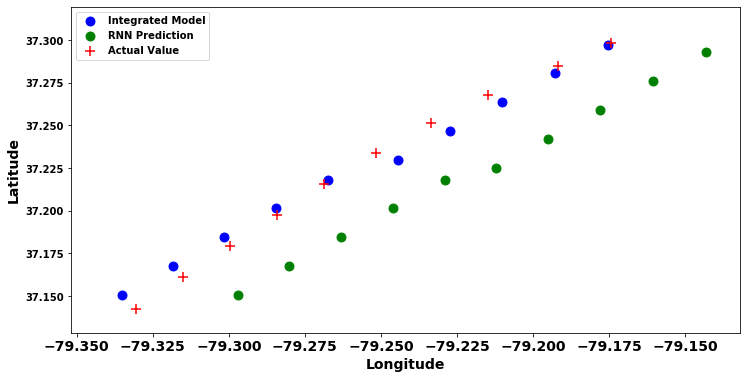

In [51]:
lat_lng_model_comparsion()

In [52]:
mean_absolute_error(multi_pred_no_DNN[:, 4:6], actual_val[s:s+10, 4:6])

0.021386198387454057

In [53]:
mean_absolute_error(multi_pred_with_DNN[:, 4:6], actual_val[s:s+10, 4:6])

0.0038832929864856423

In [54]:
# with open(flight_ID + '-' + 'results.pkl', 'wb') as f:
#      pickle.dump([DNN_loss, DNN_reduction, RNN_loss, RNN_reduction], f)
    
# with open(flight_ID + '-' + 'correction.pkl', 'wb') as f:
#     pickle.dump(correction, f)
    
# with open(flight_ID + '-' + 'pro_prediction.pkl', 'wb') as f:
#     pickle.dump([RNN_pos_p, RNN_state_p], f)

In [67]:
import pickle

AA598_res = open(flight_ID + '-results.pkl', 'rb')
res = pickle.load(AA598_res)

DNN_loss = np.array(res[0])

print ('====================  ....DNN model.... =========================')
print ('====================  Root mean squared error =========================')
print ('DNN deterministic model: Lat --> ', np.mean(np.sqrt(DNN_loss[:, 0])), '; Lng --> ', np.mean(np.sqrt(DNN_loss[:, 1])))
print ('DNN probabilistic model: Lat --> ', np.mean(np.sqrt(DNN_loss[:, 2])), '; Lng --> ', np.mean(np.sqrt(DNN_loss[:, 3])))

print ('====================  Mean absolute error =========================')
print ('DNN deterministic model: Lat --> ', np.mean(DNN_loss[:, 4]), '; Lng --> ', np.mean(DNN_loss[:, 5]))
print ('DNN probabilistic model: Lat --> ', np.mean(DNN_loss[:, 6]), '; Lng --> ', np.mean(DNN_loss[:, 7]))

print ('====================  Spatial distance    =========================')
print ('DNN deterministic model: spatial dist --> ', np.mean(DNN_loss[:, 8]), 
       '; probabilistic model spatial dist --> ', np.mean(DNN_loss[:, 9]))
print ('\n')


RNN_loss = np.array(res[2])

print ('====================  .... LSTM model .... =========================')
print ('====================  Root mean squared error =========================')
print ('RNN LSTM       model: Lat --> ', np.mean(RNN_loss[:, 0]), '; Lng --> ', np.mean(RNN_loss[:, 1]), \
                    '; Alt --> ', np.mean(RNN_loss[:, 4]), '; X velocity --> ', np.mean(np.sqrt(RNN_loss[:, 5])), \
                    '; Y velocity --> ', np.mean(np.sqrt(RNN_loss[:, 6])))

print ('RNN integrated model: Lat --> ', np.mean(RNN_loss[:, 2]), '; Lng --> ', np.mean(RNN_loss[:, 3]))

print ('====================  Mean absolute error =========================')
print ('RNN LSTM       model: Lat --> ', np.mean(RNN_loss[:, 7]), '; Lng --> ', np.mean(RNN_loss[:, 8]), \
                    '; Alt --> ', np.mean(RNN_loss[:, 11]), '; X velocity --> ', np.mean(RNN_loss[:, 12]), \
                    '; Y velocity --> ', np.mean(RNN_loss[:, 13]))

print ('RNN integrated model: Lat --> ', np.mean(RNN_loss[:, 9]), '; Lng --> ', np.mean(RNN_loss[:, 10]))

====================  ....DNN model.... =========================
====================  Root mean squared error =========================
DNN deterministic model: Lat -->  0.0008467573550025812 ; Lng -->  0.0009280279713061197
DNN probabilistic model: Lat -->  0.0008288327311803689 ; Lng -->  0.0009003515710096197
====================  Mean absolute error =========================
DNN deterministic model: Lat -->  0.0006057260326899916 ; Lng -->  0.0006484171196048398
DNN probabilistic model: Lat -->  0.0005823370089485561 ; Lng -->  0.0006172760901735971
====================  Spatial distance    =========================
DNN deterministic model: spatial dist -->  0.059294232731700376 ; probabilistic model spatial dist -->  0.05679761355560349


====================  .... LSTM model .... =========================
====================  Root mean squared error =========================
RNN LSTM       model: Lat -->  0.029292595732942864 ; Lng -->  0.034202973168735155 ; Alt -->  720.3683

In [68]:
(0.00920765831440378 * 70)**2 + (0.00928578034162216*70)**2

0.8379327721195615